In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

In [2]:
#Uploading data from the first part of a project
cleaned_dsi = pd.read_csv('cleaned_dsi.csv')
cleaned_dsi

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
3,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass
4,AAA,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass
...,...,...,...,...,...,...,...,...,...,...,...,...
21557,GGG,2014J,2620947,F,Scotland,A Level or Equivalent,80-90%,0-35,0,30,Y,Pass
21558,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail
21559,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Pass
21560,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass


In [3]:
#Uploading the rest of the data
studentVle = pd.read_csv("C:\\Users\\drinc\\OneDrive\\Desktop\\IDS project\\studentVle.csv")
Vle = pd.read_csv("C:\\Users\\drinc\\OneDrive\\Desktop\\IDS project\\vle.csv")

In [4]:
#Merging tables for the further analysis
Vle_merge = pd.merge(Vle, studentVle, on=['code_module', 'code_presentation', 'id_site'], how='left')
Vle_merge

,id_site,code_module,code_presentation,activity_type,week_from,week_to,id_student,date,sum_click
0,546943,AAA,2013J,resource,NaN,NaN,75091.0,-10.0,1.0
1,546943,AAA,2013J,resource,NaN,NaN,186149.0,-10.0,1.0
2,546943,AAA,2013J,resource,NaN,NaN,205350.0,-10.0,2.0
3,546943,AAA,2013J,resource,NaN,NaN,1626710.0,-9.0,1.0
4,546943,AAA,2013J,resource,NaN,NaN,2643002.0,-8.0,1.0
...,...,...,...,...,...,...,...,...,...
10655371,897100,GGG,2014J,resource,NaN,NaN,656053.0,1.0,1.0
10655372,897100,GGG,2014J,resource,NaN,NaN,688819.0,1.0,1.0
10655373,897100,GGG,2014J,resource,NaN,NaN,642694.0,15.0,1.0
10655374,897100,GGG,2014J,resource,NaN,NaN,639251.0,117.0,1.0


In [5]:
def create_vector_strings(vle_df, student_df):
    # Filter for the date range 0 to 244
    filtered_vle_df = vle_df[(vle_df['date'] >= 0) & (vle_df['date'] <= 244)]

    # Group by student, course, and date, then aggregate clicks
    grouped_vle_df = filtered_vle_df.groupby(['id_student', 'code_module', 'code_presentation', 'date'])['sum_click'].sum().reset_index()

    # Pivot the table to get a matrix of students, courses, and dates
    pivot_df = grouped_vle_df.pivot_table(index=['id_student', 'code_module', 'code_presentation'],
                                          columns='date',
                                          values='sum_click',
                                          fill_value=0)

    # Create strings for Interactions Vector (binary) and Clicks Vector
    interactions_vector_str = pivot_df.applymap(lambda x: '1' if x > 0 else '0').agg(lambda x: ','.join(x), axis=1)
    clicks_vector_str = pivot_df.applymap(str).agg(lambda x: ','.join(x), axis=1)

    # Create a DataFrame for merging
    vector_df = pd.DataFrame({
        'id_student': interactions_vector_str.index.get_level_values('id_student'),
        'code_module': interactions_vector_str.index.get_level_values('code_module'),
        'code_presentation': interactions_vector_str.index.get_level_values('code_presentation'),
        'interactions_vector': interactions_vector_str.values,
        'clicks_vector': clicks_vector_str.values
    })

    # Merge with student data
    merged_df = student_df.merge(vector_df, on=['id_student', 'code_module', 'code_presentation'], how='left')

    return merged_df

# Example usage
merged_student_df = create_vector_strings(Vle_merge, cleaned_dsi)
merged_student_df

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,interactions_vector,clicks_vector
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,"1,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,...","49,127,4,0,0,0,3,0,0,20,0,0,0,0,0,0,0,51,49,0,..."
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,"1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,...","48,16,0,0,29,9,73,7,59,0,0,0,0,0,0,0,37,0,0,0,..."
2,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,"0,1,0,0,0,0,0,1,0,1,1,1,1,1,1,0,1,1,1,0,1,0,1,...","0,22,0,0,0,0,0,29,0,41,19,7,52,6,4,0,41,5,49,0..."
3,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,"0,1,1,1,1,0,1,0,0,0,1,1,1,1,0,0,0,0,1,1,1,1,0,...","0,17,11,11,8,0,14,0,0,0,40,34,11,31,0,0,0,0,24..."
4,AAA,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass,"1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,...","48,11,13,0,26,11,26,24,70,6,24,9,0,8,15,12,12,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21557,GGG,2014J,2620947,F,Scotland,A Level or Equivalent,80-90%,0-35,0,30,Y,Pass,"0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,...","0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,0,9,..."
21558,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail,"1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,...","1,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,17,0,5,0,0,..."
21559,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Pass,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,20,0,..."
21560,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass,"0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."


In [6]:
def prepare_visualization(merged_student_df):
    # Extract clicks vector data from the merged DataFrame
    clicks_data = pd.DataFrame(merged_student_df['clicks_vector'].apply(lambda x: [int(i) if i.isdigit() else 0 for i in str(x).split(',')]).tolist())

    # Replace 'nan' values with 0
    clicks_data = clicks_data.replace('nan', 0)

    # Calculate accumulated clicks per day
    accumulated_clicks = clicks_data.sum()

    # Count the number of students who interacted each day
    students_interacted = (clicks_data > 0).sum()

    return accumulated_clicks, students_interacted

# Example usage
accumulated_clicks, students_interacted = prepare_visualization(merged_student_df)

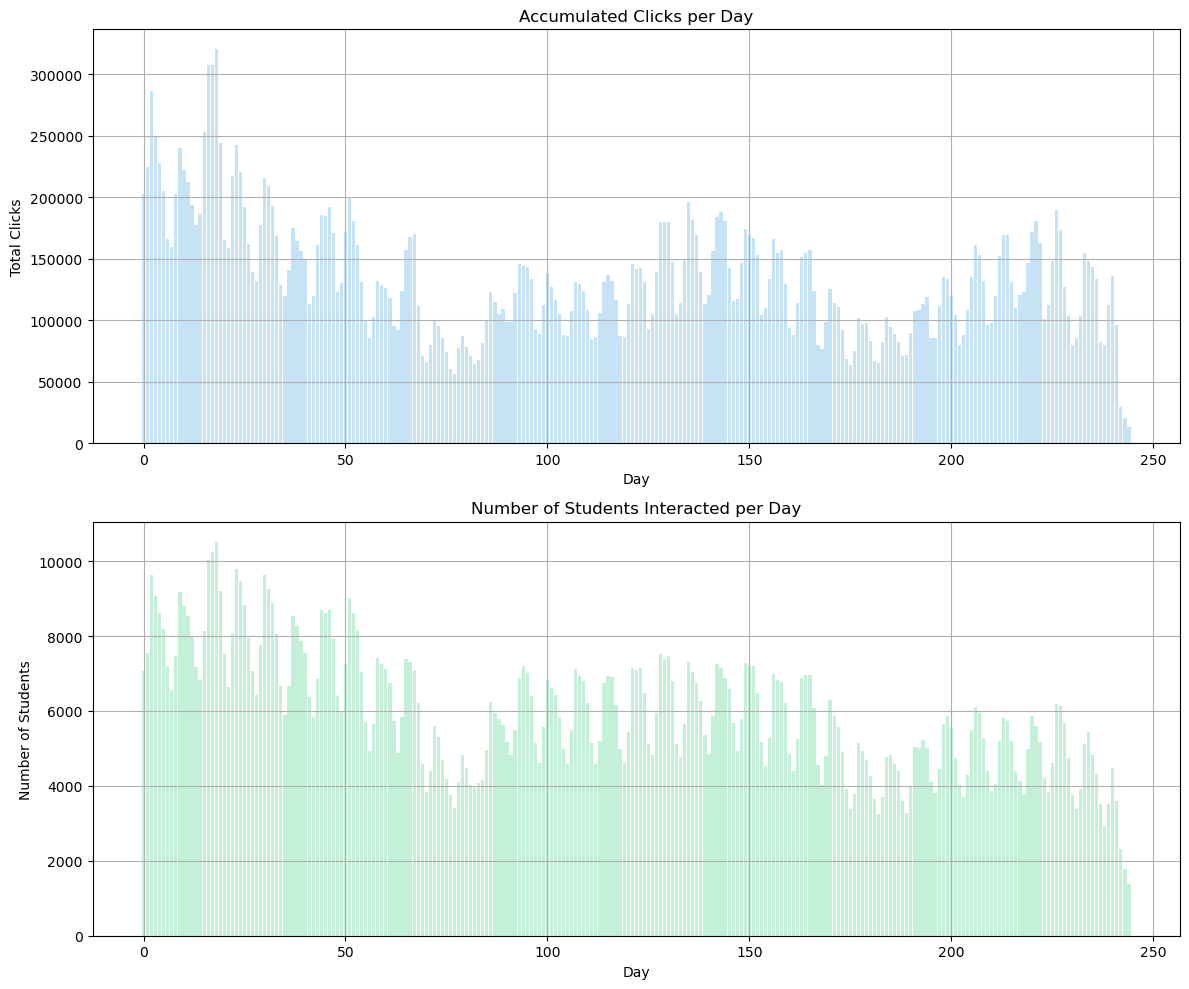

In [7]:
def create_pastel_bar_charts(accumulated_clicks, students_interacted):
    # Define pastel colors
    pastel_blue = '#AED6F1'
    pastel_green = '#ABEBC6'

    # Create the bar charts
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

    # Bar chart for Accumulated Clicks
    axes[0].bar(np.arange(len(accumulated_clicks)), accumulated_clicks, color=pastel_blue, alpha=0.7)
    axes[0].set_title('Accumulated Clicks per Day')
    axes[0].set_xlabel('Day')
    axes[0].set_ylabel('Total Clicks')
    axes[0].grid(True)

    # Bar chart for Number of Students Interacted
    axes[1].bar(np.arange(len(students_interacted)), students_interacted, color=pastel_green, alpha=0.7)
    axes[1].set_title('Number of Students Interacted per Day')
    axes[1].set_xlabel('Day')
    axes[1].set_ylabel('Number of Students')
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Example usage
create_pastel_bar_charts(accumulated_clicks, students_interacted)